#### 1. Load and Preprocess raw data from customers  <br>
The preprocessing step involves computation of first order differences of the cumulative raw Other Consumption data ('Ea_cum'). <br>
ToDo: find a better way to fill NaN in dataPreprocessorOtherConsumption function

In [1]:
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math

In [2]:
def reject_outliers(data, m = 5.):

    x = data.where(abs(data - np.mean(data)) < m * np.std(data),  np.nan)
    #TODO interpolate or replace with before 
    print(np.isnan(x).sum())
    #x.fillna(x.shift(periods=-1,axis=0), inplace=True)
    x = x.interpolate()
    return x

In [3]:
def dataPreprocessorOtherConsumption(file_path, sample, name):
    df5 = pd.read_csv(file_path)
    df5 = df5.set_index(pd.to_datetime(df5['ts']))
    df5 = df5.resample(sample).mean()
    df5 = df5[name]
    df5 = reject_outliers(df5, m = 5.)
    df5 = df5.to_frame()
    return df5

In [4]:
df = dataPreprocessorOtherConsumption('energy_zell.csv', '15T', 'Active energy plant input')

1652


In [5]:
df

,Active energy plant input
ts,
2018-01-01 00:00:00,892.0
2018-01-01 00:15:00,892.0
2018-01-01 00:30:00,840.0
2018-01-01 00:45:00,720.0
2018-01-01 01:00:00,756.0
...,...
2023-03-15 23:00:00,1728.0
2023-03-15 23:15:00,1728.0
2023-03-15 23:30:00,1728.0


In [6]:
df.shape


(182401, 1)

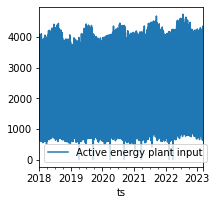

In [7]:
df.plot(kind='line', subplots=True, layout=(3,3), figsize=(10,10))
plt.show()

In [8]:
df = df.values

In [9]:
print(type(df))

<class 'numpy.ndarray'>


In [10]:
#hardcoded values
Input = 672 #4320 2304 2016 
output = 96# 576 300 288
Intervall = 10 # 15min => 3 1h => 12 1T => 288 1T1h => 300 5min=> 1 5h => 12*5

In [11]:
def createdataset(df = None,input_len = 1 ,output_len =1 ,intervall = 1,return_ = True):
    z= list()
    data = df
    n = int(len(data)/intervall)
    for i in range(n):
        ii = i*intervall
        # define the end of the output sequence
        out_end = len(data)-ii
        in_start = len(data)-ii-output_len-input_len

        # ensure we have enough data for this instance
        if in_start >= 0:
            whole_data = data[in_start:out_end,0]
            sumnan = np.isnan(whole_data).sum()
            if sumnan > 0:
                continue
            z.append(whole_data)
    z = np.array(z)
    if return_:
        return z

In [12]:
# 1 week 1 day 2016 288
data= createdataset(df=df, input_len =Input, output_len=output , intervall=Intervall)
print(data.shape)

(18164, 768)


In [13]:
# 2 Shuffle
split = int((data.shape[0]/100)*80)
train_multi = data[0:split]
val_multi = data[split:]
valMultitest = val_multi

#### 5. Scaling or normalization. Standardization is a better option as the overall data has been sampled from different distributions, but computationally intensive.

In [14]:
from sklearn.preprocessing import StandardScaler
def scaling(data):
    """""
        Params
        ======
            data:  pandas dataframe containing preprocessed data
        Returns
        --------
             standardized data
        """
    scaler = MinMaxScaler(feature_range = (0, 1))
    rows, cols = data.shape[0], data.shape[1]
    data = data.reshape((rows*cols, 1))
    data = scaler.fit_transform(data)
    data = data.reshape((rows, cols))
    print(data.shape)
    return data, scaler

In [15]:
df_train = pd.DataFrame(train_multi)
df_train_shuffle = df_train.sample(frac=1,axis=0, random_state=42)
df_train_shuffle= df_train_shuffle.to_numpy()

df_val = pd.DataFrame(val_multi)
df_val_shuffle = df_val.sample(frac=1,axis=0, random_state=42)
df_val_shuffle= df_val_shuffle.to_numpy()

In [16]:
train_multi, scaler_train = scaling(df_train_shuffle)
val_multi, scaler_val = scaling(df_val_shuffle)


(14531, 768)
(3633, 768)


In [17]:
def split_train_predict(df):
    X, y = list(), list()
    data = df
    n = int(len(data))
    for i in range(n):
        out_end = Input + output#2304
        out_start = Input#2016
        in_end = Input#2016
        in_start = 0
        sumnan = np.isnan(data[i]).sum()
        # ensure we have enough data for this instance
        if sumnan == 0:
            in_data = data[i][in_start:in_end]
            out_data = data[i][out_start:out_end]         
            X.append(in_data)
            y.append(out_data)
    X = np.array(X)
    y = np.array(y)
    return X, y

In [18]:
x_train_multi, y_train_multi = split_train_predict(df=train_multi)
x_val_multi, y_val_multi = split_train_predict(df=val_multi)

In [19]:
x_train_multi = x_train_multi.reshape((x_train_multi.shape[0], x_train_multi.shape[1],1))
x_val_multi = x_val_multi.reshape((x_val_multi.shape[0], x_val_multi.shape[1],1))

In [20]:
print(x_train_multi.shape)
print(y_train_multi.shape)

(14531, 672, 1)
(14531, 96)


#### 6. Training

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM, Embedding 
from tensorflow.keras import initializers
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf

In [22]:

multi_step_model = tf.keras.models.Sequential()
#1
"""multi_step_model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='tanh',  input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=2, activation='tanh'))
multi_step_model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=2, activation='tanh'))
multi_step_model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
multi_step_model.add(tf.keras.layers.Flatten())
multi_step_model.add(tf.keras.layers.RepeatVector(300))
multi_step_model.add(tf.keras.layers.LSTM(50, activation='tanh'))
multi_step_model.add(tf.keras.layers.Dropout(0.2))
multi_step_model.add(tf.keras.layers.Dense(1500))
"""
multi_step_model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='tanh',  input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=2, activation='tanh'))
multi_step_model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=2, activation='tanh'))
multi_step_model.add(MaxPooling1D(pool_size=2))
multi_step_model.add(LSTM(50, activation='tanh', return_sequences=True))
multi_step_model.add(tf.keras.layers.Dropout(0.2))
multi_step_model.add(Flatten())
multi_step_model.add(tf.keras.layers.Dense(96))


#2

"""multi_step_model.add(Conv1D(filters=64, kernel_size=2, activation='tanh',  input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(Conv1D(filters=32, kernel_size=2, activation='tanh'))
multi_step_model.add(Conv1D(filters=16, kernel_size=2, activation='tanh'))
multi_step_model.add(MaxPooling1D(pool_size=2))
multi_step_model.add(LSTM(50, activation='tanh', return_sequences=True))
multi_step_model.add(tf.keras.layers.Dropout(0.2))
multi_step_model.add(Flatten())
multi_step_model.add(tf.keras.layers.Dense(1500))
"""
multi_step_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='mse')
print(multi_step_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 671, 64)           192       
                                                                 
 conv1d_1 (Conv1D)           (None, 670, 32)           4128      
                                                                 
 conv1d_2 (Conv1D)           (None, 669, 16)           1040      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 334, 16)          0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 334, 50)           13400     
                                                                 
 dropout (Dropout)           (None, 334, 50)           0         
                                                        

C:\Users\marcb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [23]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights=True)
filepath = 'my_best_model_hummel.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint, early_stopping]
#multi_step_model = tf.keras.models.load_model('bestmodel_300lstm_6intervall.h5')
multi_step_history = multi_step_model.fit(x_train_multi,
                y_train_multi,
                epochs=15,
                #steps_per_epoch=50,
                #validation_split=0.2,
                validation_data=(x_val_multi,y_val_multi),
                shuffle=True,
                callbacks=callbacks,
                batch_size = 64)

Epoch 1/15
228/228 [==============================] - ETA: 0s - loss: 0.0149
Epoch 1: val_loss improved from inf to 0.01273, saving model to my_best_model_hummel.hdf5
228/228 [==============================] - 41s 176ms/step - loss: 0.0149 - val_loss: 0.0127
Epoch 2/15
228/228 [==============================] - ETA: 0s - loss: 0.0092
Epoch 2: val_loss improved from 0.01273 to 0.01214, saving model to my_best_model_hummel.hdf5
228/228 [==============================] - 41s 179ms/step - loss: 0.0092 - val_loss: 0.0121
Epoch 3/15
228/228 [==============================] - ETA: 0s - loss: 0.0089
Epoch 3: val_loss did not improve from 0.01214
228/228 [==============================] - 41s 179ms/step - loss: 0.0089 - val_loss: 0.0132
Epoch 4/15
228/228 [==============================] - ETA: 0s - loss: 0.0083
Epoch 4: val_loss improved from 0.01214 to 0.01186, saving model to my_best_model_hummel.hdf5
228/228 [==============================] - 41s 180ms/step - loss: 0.0083 - val_loss: 0.0119

# Prediction


In [24]:
predict = multi_step_model.predict(x_val_multi)

In [25]:
predict = predict.reshape((predict.shape[0], predict.shape[1]))
x_val_multi_scale = x_val_multi.reshape((x_val_multi.shape[0], x_val_multi.shape[1]))

In [26]:
predicted = scaler_train.inverse_transform(predict)
x_valscaled = scaler_train.inverse_transform(x_val_multi_scale)
y_val_multi = scaler_val.inverse_transform(y_val_multi)

          true         pred
0       3884.0  3733.225098
1       4016.0  3725.508301
2       3956.0  3686.612305
3       3772.0  3690.080078
4       3768.0  3720.825195
...        ...          ...
348763   768.0   861.796509
348764   744.0   764.529175
348765   876.0   650.042358
348766   944.0   627.166138
348767   696.0   677.162598

[348768 rows x 2 columns]


<function matplotlib.pyplot.show(close=None, block=None)>

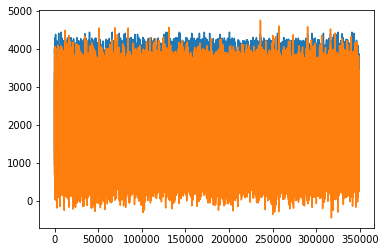

In [27]:
#TODO Display predictions
y = tf.reshape(y_val_multi,[-1])
x = predicted.flatten()
comparison = pd.DataFrame(data={
    "true": y[:],
    "pred": x[:]
    })
print(comparison)
plt.plot(comparison)
plt.show

In [28]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.show()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.show()

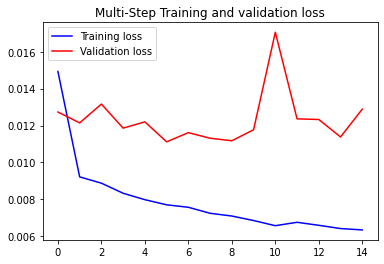

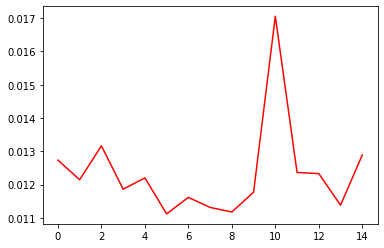

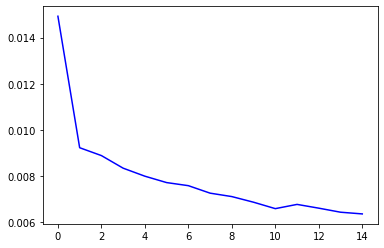

In [29]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

### Not relevant for now

MAPE
MEAN: 25.047552432490576
MEDIAN: 21.264644701583865
percentile: [13.29277304 38.7447433 ]


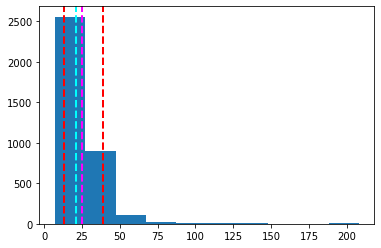

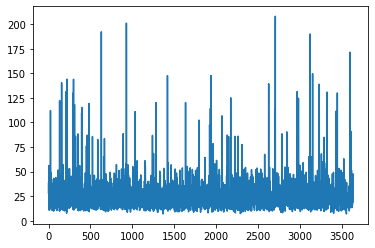

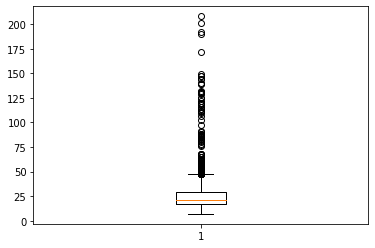

RMSE
MEAN: 491.9261538423357
MEDIAN: 445.5857709431451
percentile: [302.1541242  698.93335798]


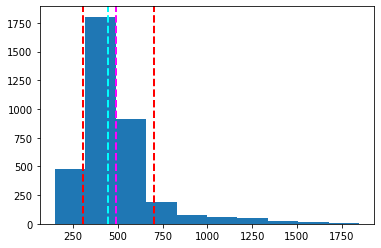

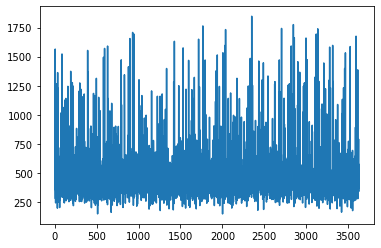

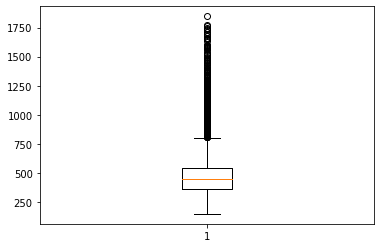

MAE
MEAN: 426.36251246850117
MEDIAN: 385.80425707499194
percentile: [247.96864656 630.68398158]


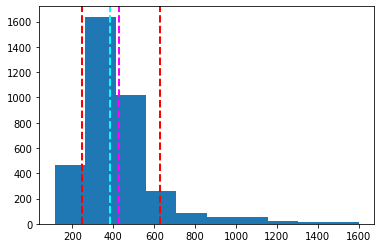

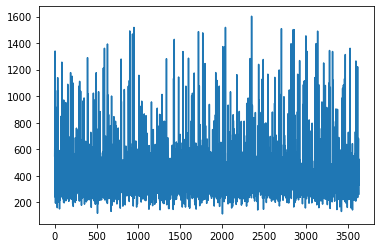

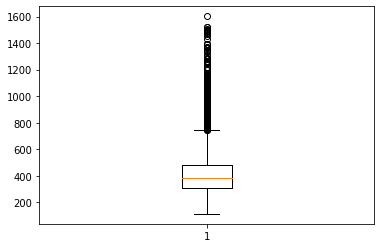

In [30]:
mape = []
RMSEs = []
MSEs = []
MAEs = []
import math
for i in range(len(predicted)):
    #plt.plot(predicted[i], color='r')
    #plt.plot(y_val_multi[i])
    #plt.show()
    MAPEs = np.absolute(((y_val_multi[i]-predicted[i]))/y_val_multi[i])*100
    MAPEsmean = MAPEs.mean()
    #print("MAPE: ",MAPEsmean)
    mape.append(MAPEsmean)
    #plt.plot(np.absolute(((y_val_multi[i]-predicted[i]))/y_val_multi[i])*100, label="MAPE")
    #plt.legend(loc="upper left")
    #plt.grid()
    #plt.title("Mean Absolute Percentage Error")
    #plt.xlabel("time")
    #plt.ylabel("%Error")
    #plt.show()
    MSE = np.square(np.subtract(y_val_multi[i],predicted[i])).mean() 
    MSEs.append(MSE)
    RMSE = math.sqrt(MSE)
    RMSEs.append(RMSE)
    y_true, predictions = np.array(y_val_multi[i]), np.array(predicted[i])
    MAE = np.mean(np.abs(y_val_multi[i] - predicted[i]))
    MAEs.append(MAE)
    
def means(dataset):
    return sum(dataset) / len(dataset)

def median(dataset):
    data = sorted(dataset)
    index = len(data) // 2
    
    # If the dataset is odd  
    if len(dataset) % 2 != 0:
        return data[index]
    
    # If the dataset is even
    return (data[index - 1] + data[index]) / 2

print("MAPE")
mape_mean = means(mape)
print("MEAN:",mape_mean)
mape_median = median(mape)
print("MEDIAN:",mape_median)
percentiles_mape = np.percentile(mape,[10,90])
print("percentile:", percentiles_mape)
plt.hist(mape)
plt.axvline(mape_mean, color='magenta', linestyle='dashed', linewidth=2)
plt.axvline(mape_median, color='cyan', linestyle='dashed', linewidth=2)
plt.axvline(percentiles_mape[0], color='red', linestyle='dashed', linewidth=2)
plt.axvline(percentiles_mape[1], color='red', linestyle='dashed', linewidth=2)
plt.show()
plt.plot(mape)
plt.show()
plt.boxplot(mape)
plt.show()

print("RMSE")
RMSEs_mean = means(RMSEs)
print("MEAN:",RMSEs_mean)
RMSEs_median = median(RMSEs)
print("MEDIAN:",RMSEs_median)
percentiles_RMSEs = np.percentile(RMSEs,[10,90])
print("percentile:", percentiles_RMSEs)
plt.hist(RMSEs)
plt.axvline(RMSEs_mean, color='magenta', linestyle='dashed', linewidth=2)
plt.axvline(RMSEs_median, color='cyan', linestyle='dashed', linewidth=2)
plt.axvline(percentiles_RMSEs[0], color='red', linestyle='dashed', linewidth=2)
plt.axvline(percentiles_RMSEs[1], color='red', linestyle='dashed', linewidth=2)
plt.show()
plt.plot(RMSEs)
plt.show()
plt.boxplot(RMSEs)
plt.show()

print("MAE")
MAEs_mean = means(MAEs)
print("MEAN:",MAEs_mean)
MAEs_median = median(MAEs)
print("MEDIAN:",MAEs_median)
percentiles_mae = np.percentile(MAEs, [10,90])
print("percentile:", percentiles_mae)
plt.hist(MAEs)
plt.axvline(MAEs_mean, color='magenta', linestyle='dashed', linewidth=2)
plt.axvline(MAEs_median, color='cyan', linestyle='dashed', linewidth=2)
plt.axvline(percentiles_mae[0], color='red', linestyle='dashed', linewidth=2)
plt.axvline(percentiles_mae[1], color='red', linestyle='dashed', linewidth=2)
plt.show()
plt.plot(MAEs)
plt.show()
plt.boxplot(MAEs)
plt.show()



RMSE 871.8209409524299
MAPE 35.619224687537475
MAE 719.6543907589382


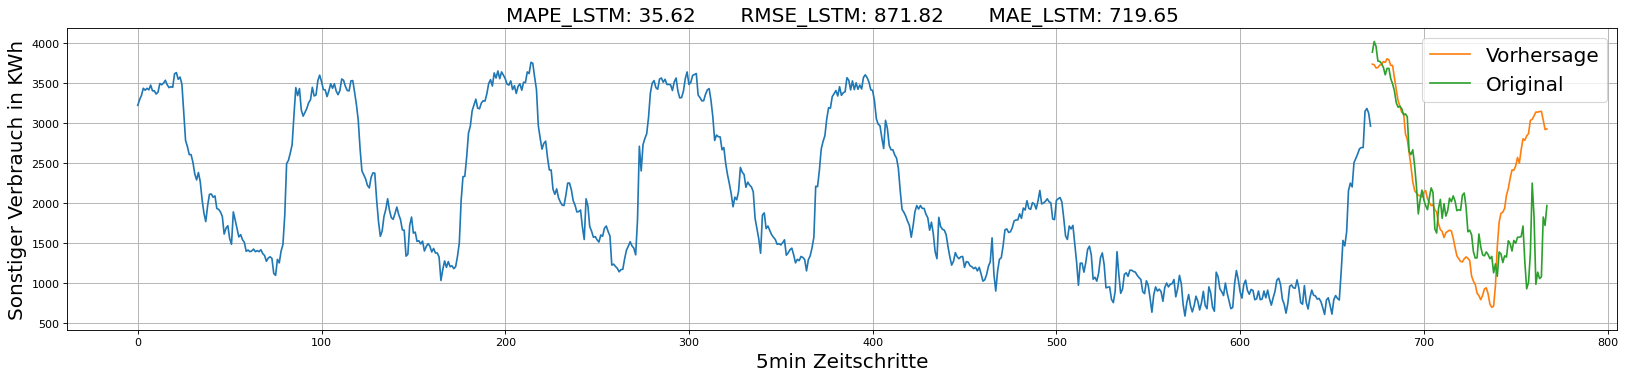

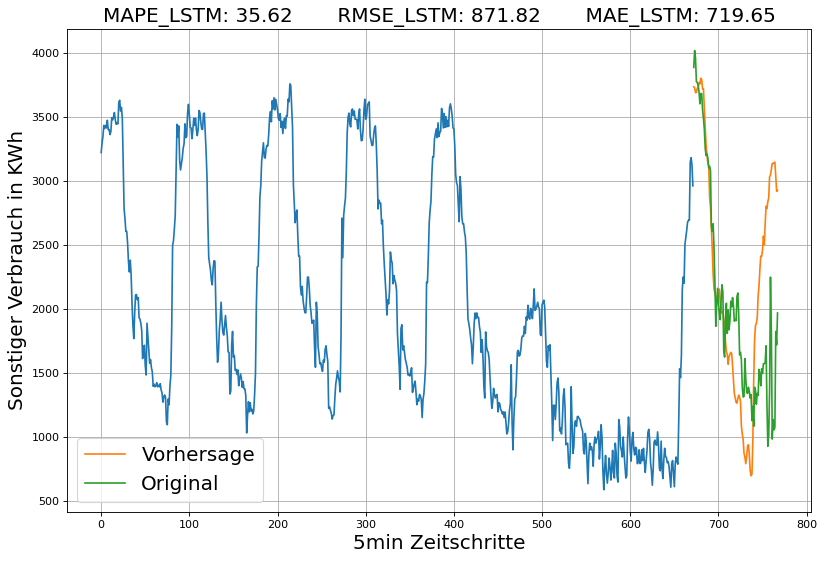

RMSE 979.3300929440396
MAPE 32.878682176276705
MAE 675.1023718516032


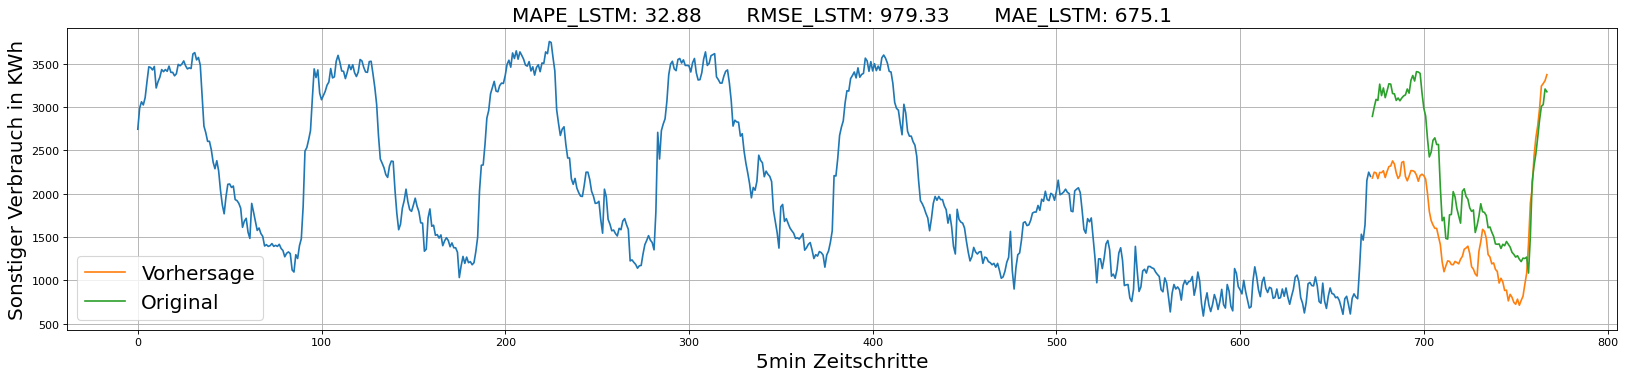

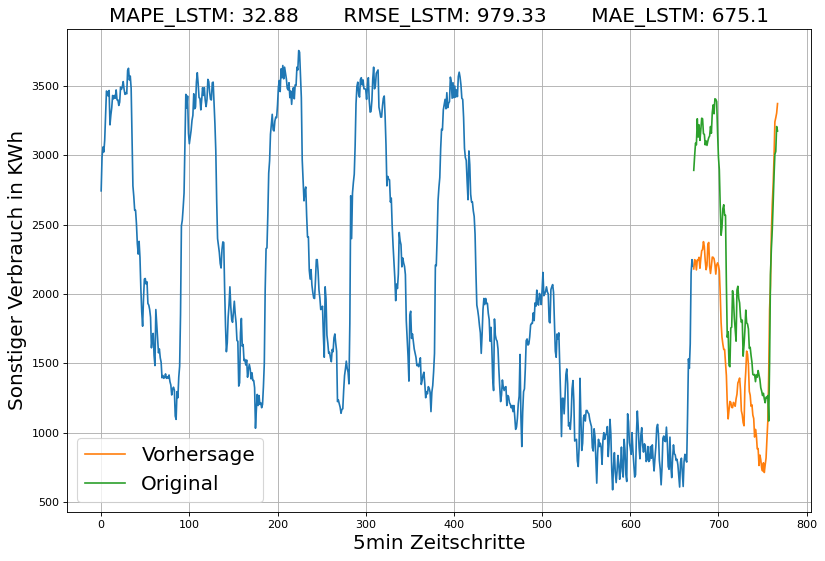

RMSE 421.67483166265174
MAPE 23.61717473556432
MAE 357.88790206114453


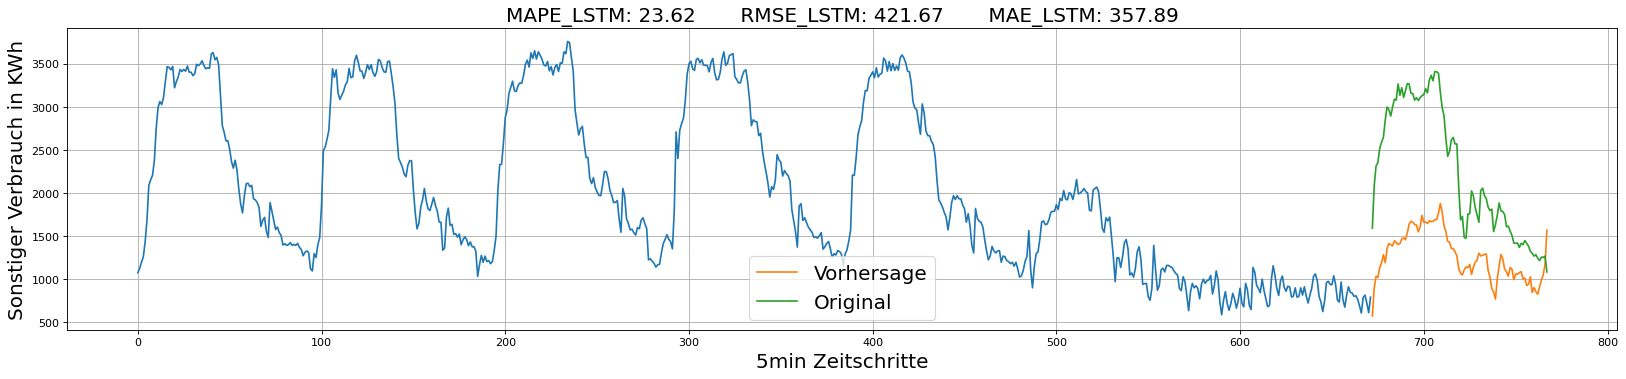

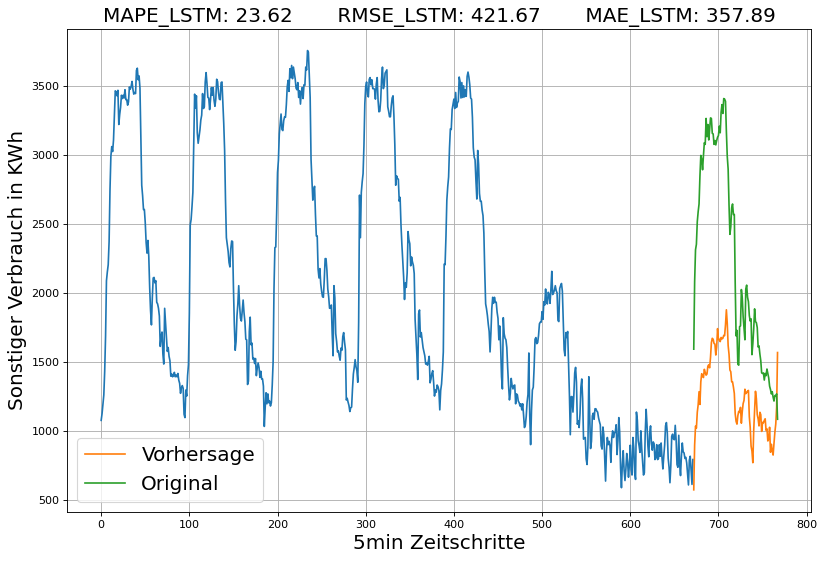

RMSE 433.6206011040908
MAPE 18.326583992067924
MAE 378.58748308817553


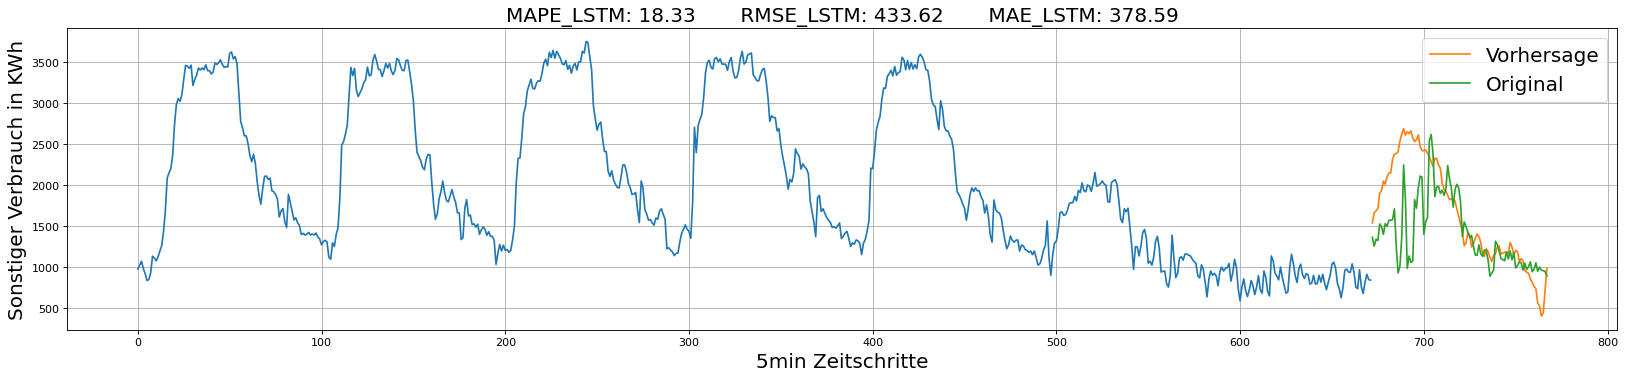

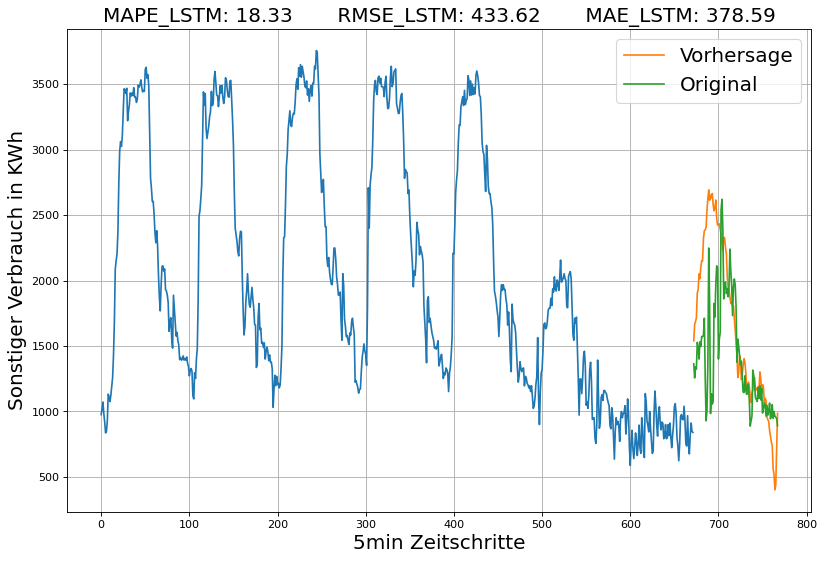

RMSE 650.67607896307
MAPE 24.263349055692345
MAE 490.36157459682886


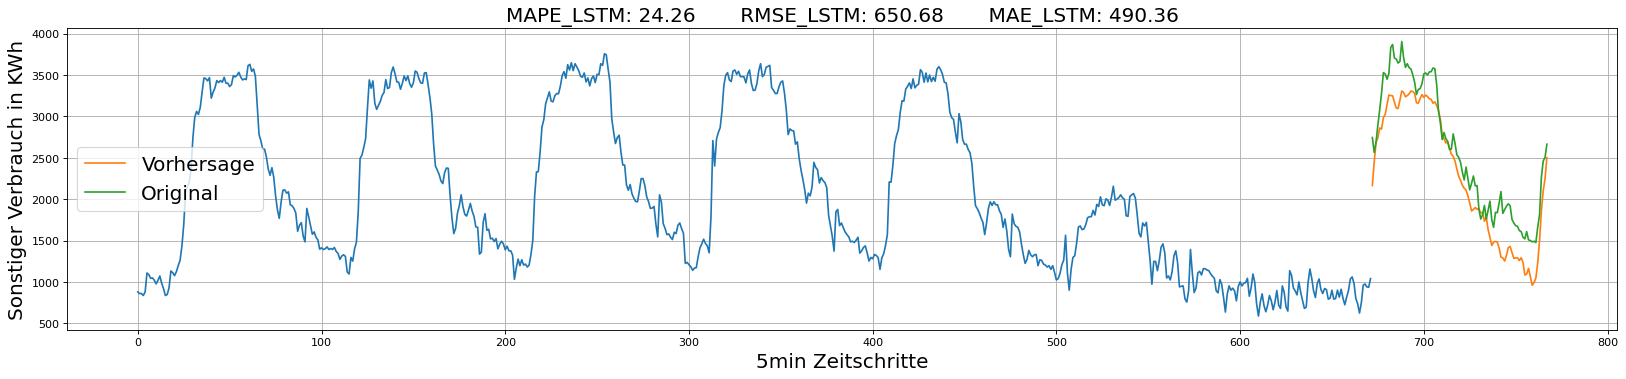

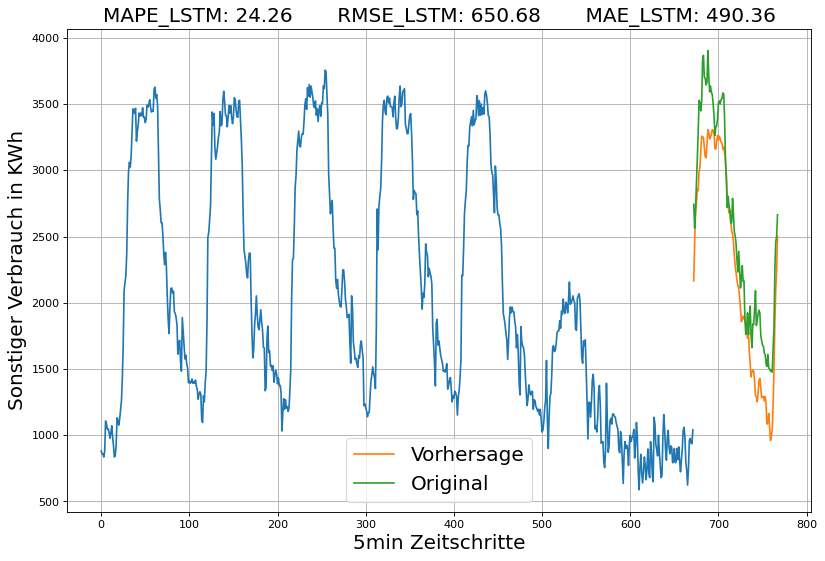

RMSE 387.66778691055816
MAPE 21.108854197486792
MAE 330.9358784357707


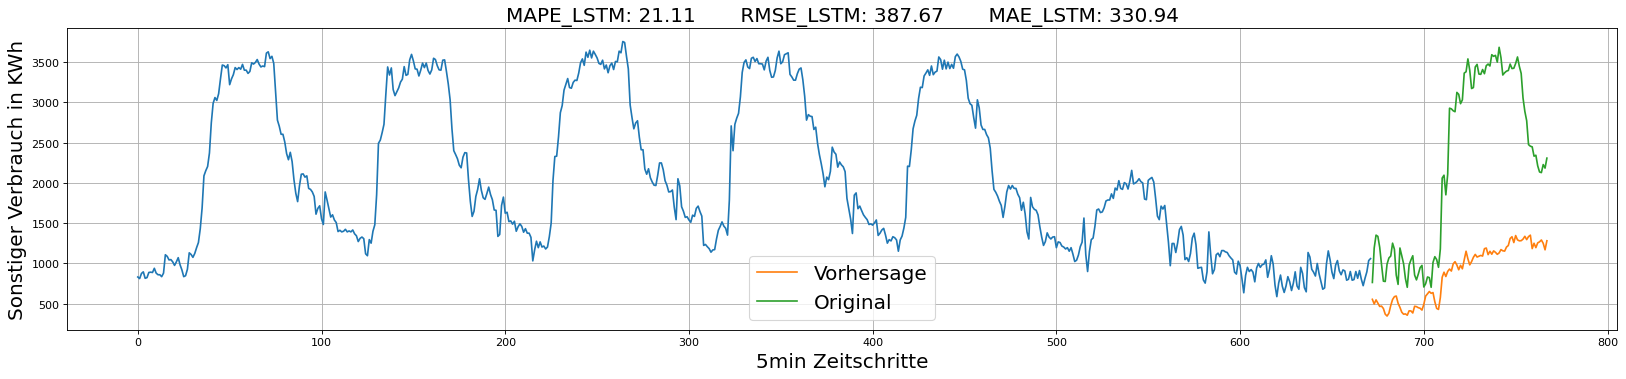

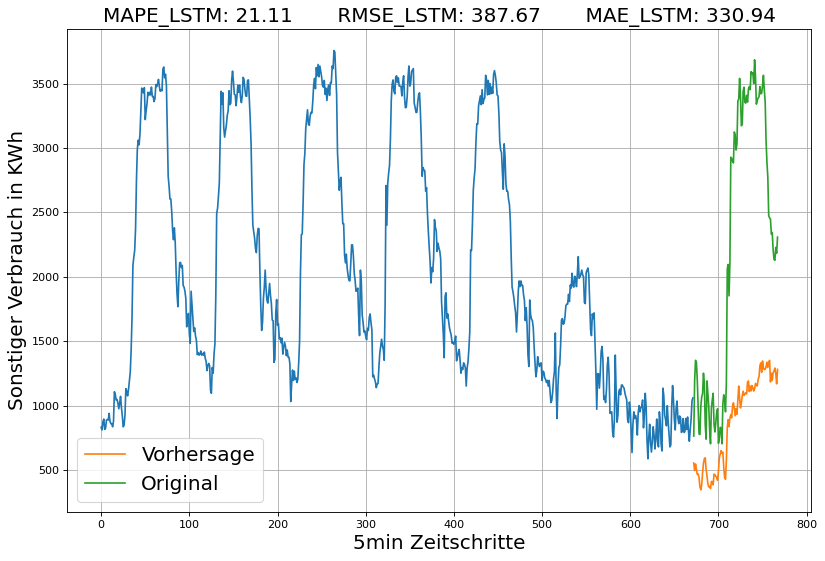

RMSE 641.1732669739463
MAPE 30.94155429528578
MAE 486.72045317292213


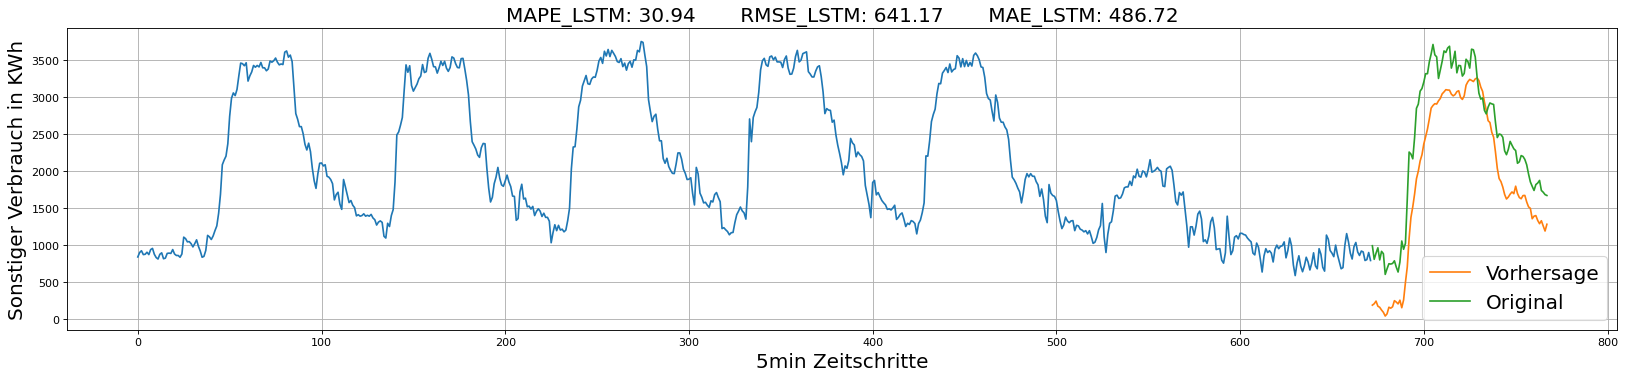

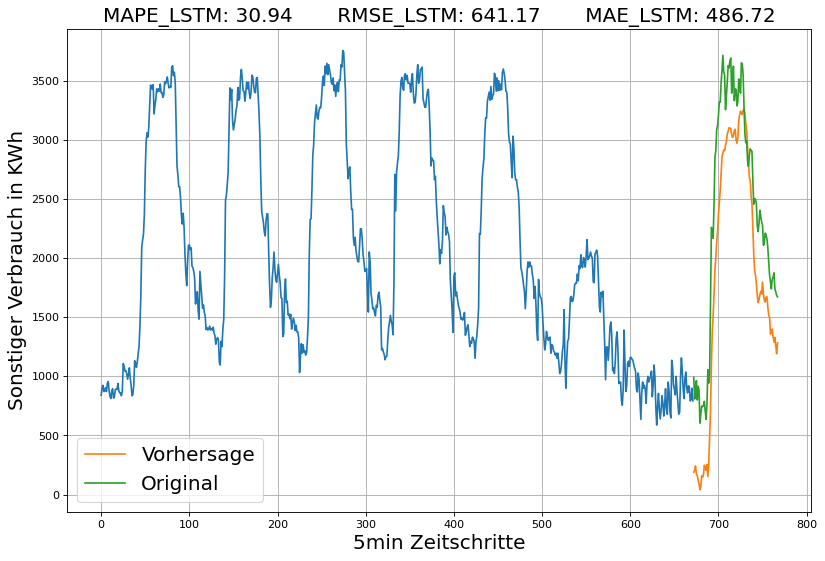

RMSE 1071.8378124232725
MAPE 57.1510626271902
MAE 756.7036199661738


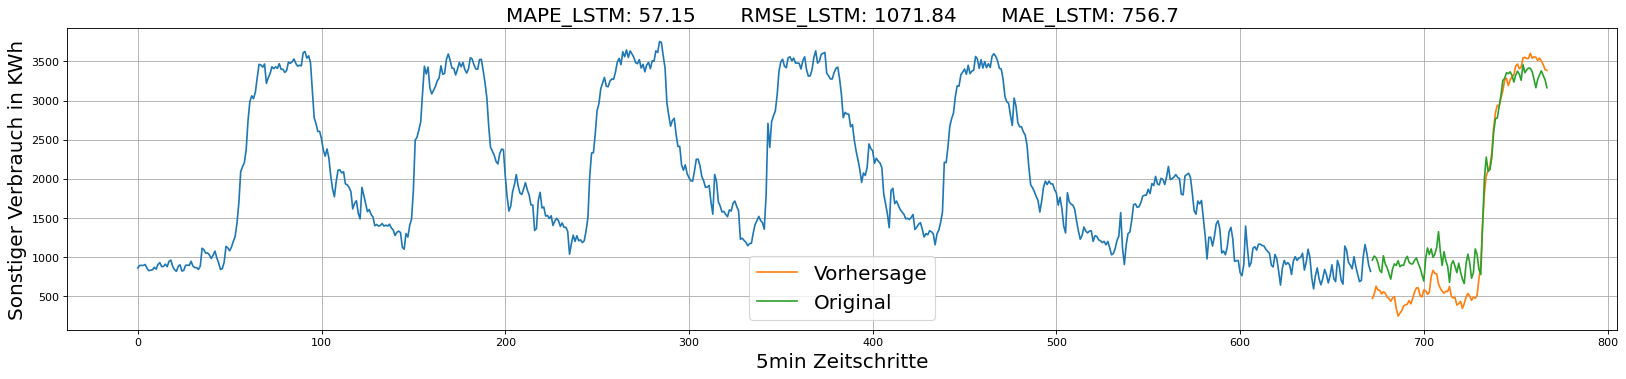

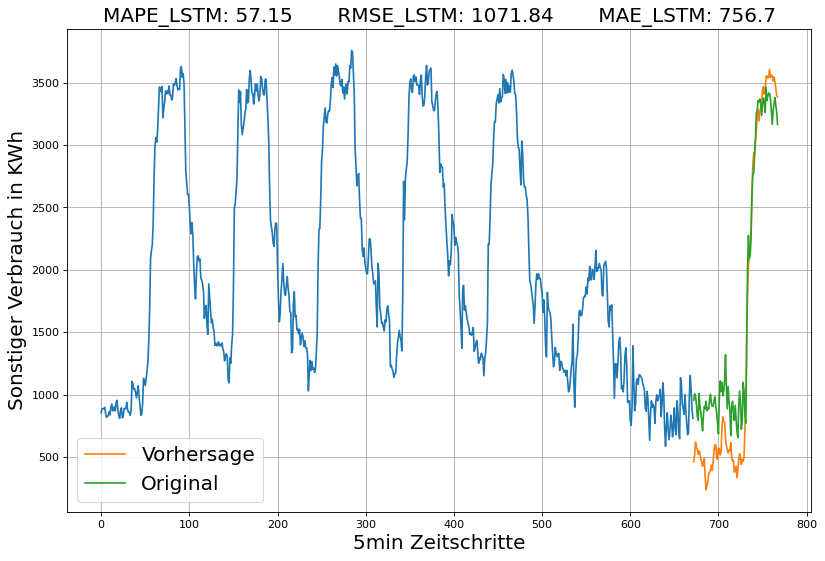

RMSE 507.9182500268302
MAPE 28.596586230909313
MAE 427.67543606708455


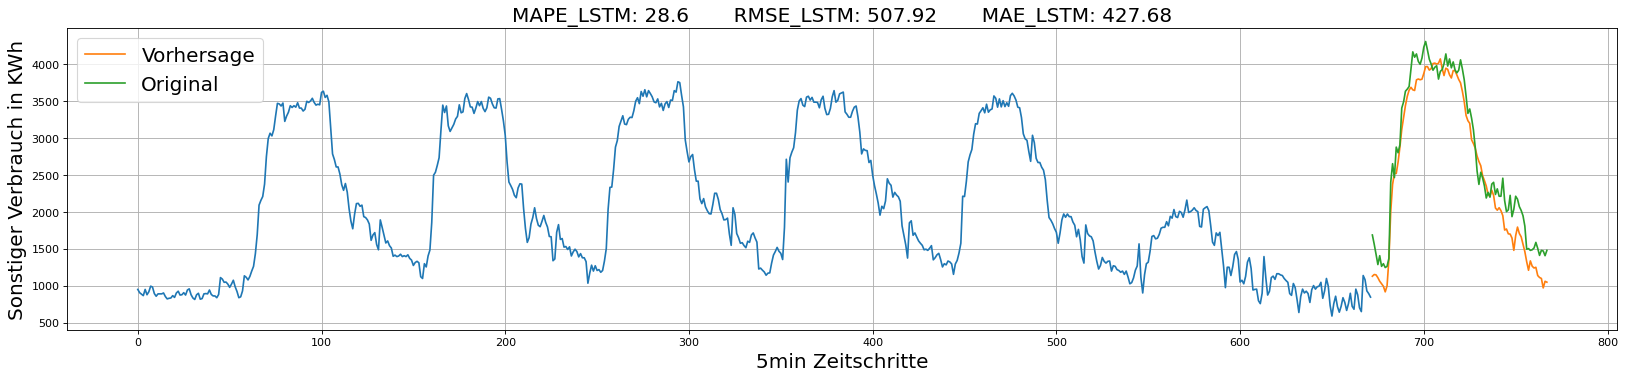

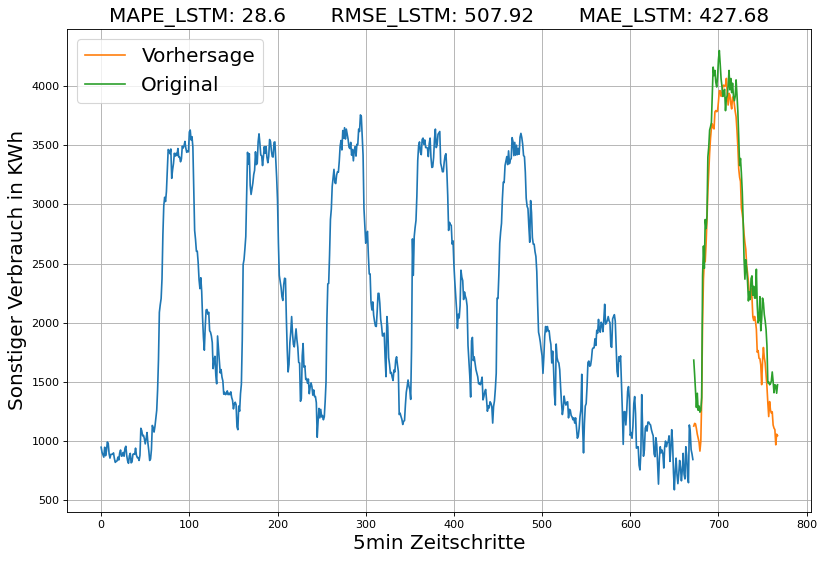

RMSE 418.8457098669886
MAPE 27.62136401306455
MAE 340.98304859259065


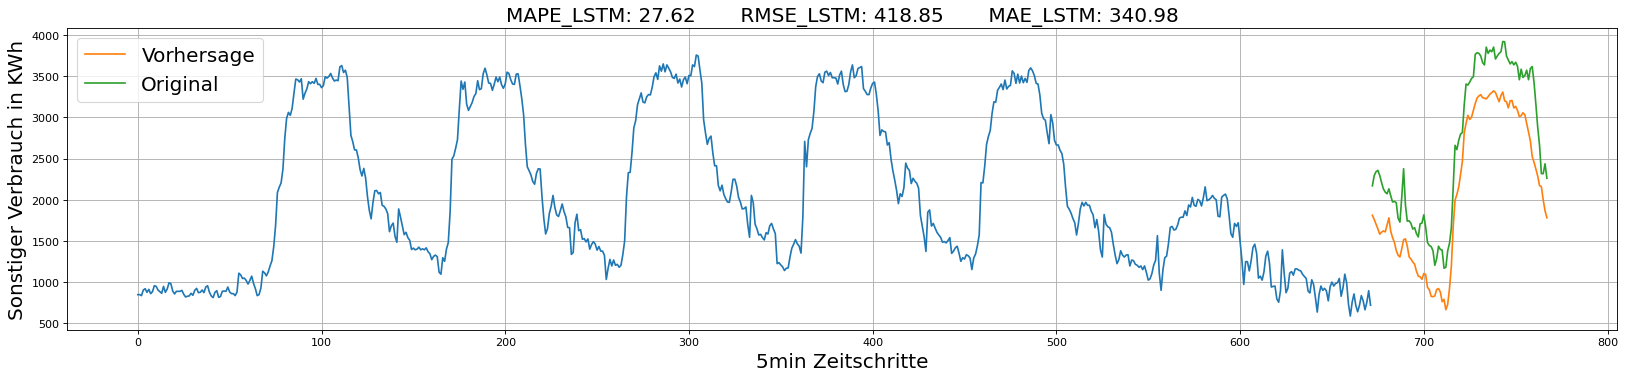

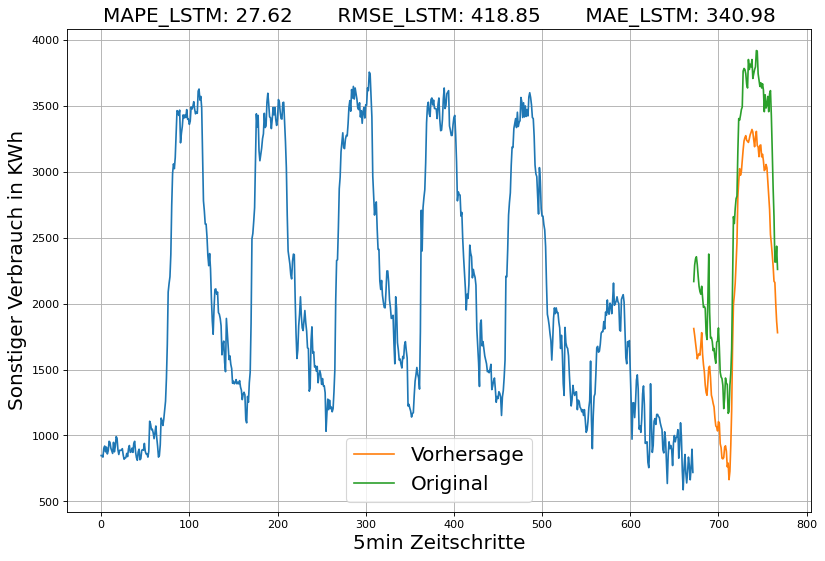

RMSE 378.97632015771785
MAPE 22.211165298464472
MAE 313.39758387586085


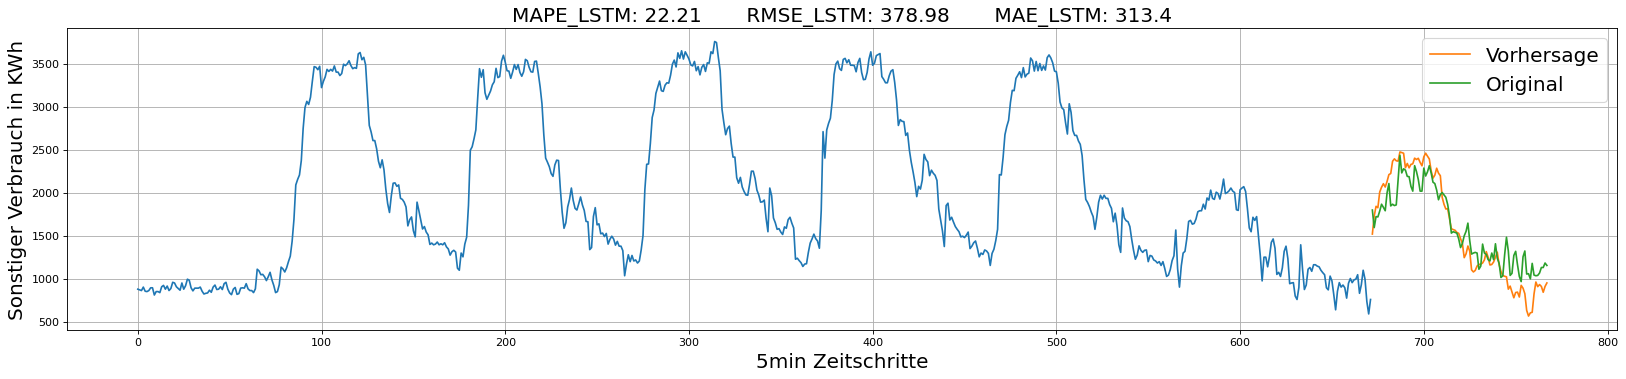

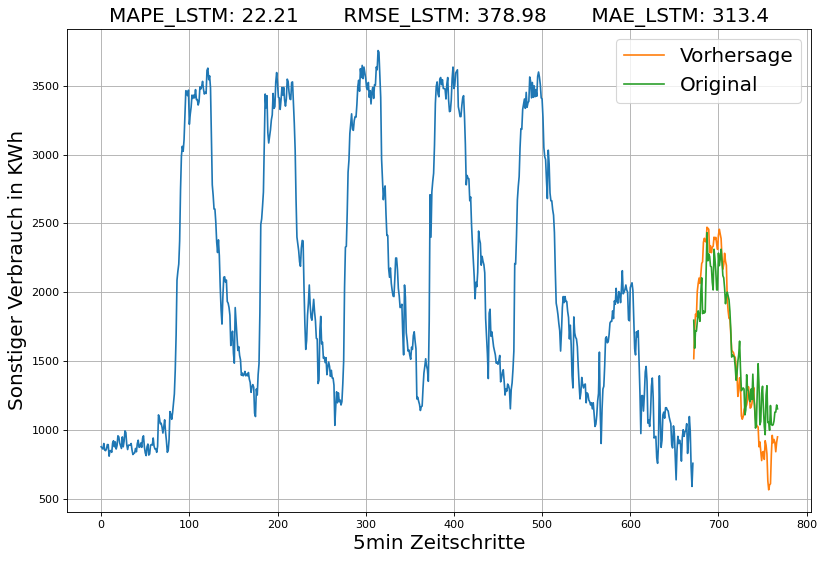

RMSE 924.2791747231913
MAPE 36.92895298615512
MAE 693.9284943130988


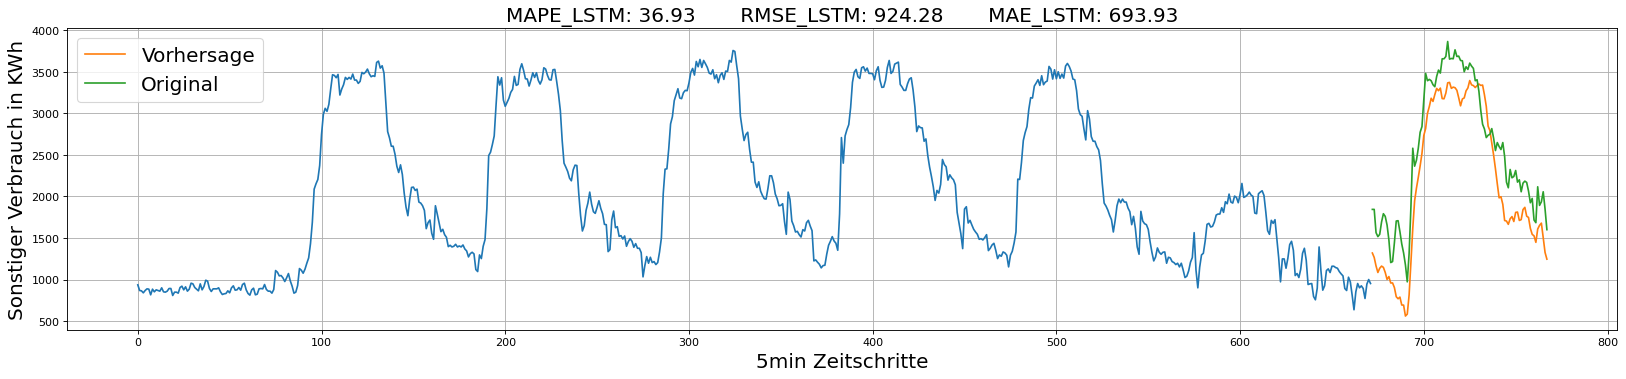

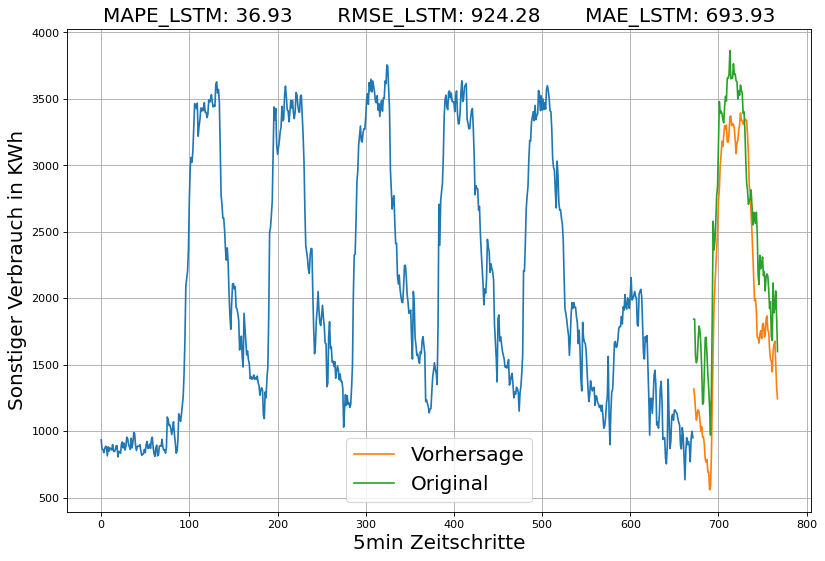

RMSE 805.7865516191797
MAPE 26.212300293804212
MAE 651.4872394137914


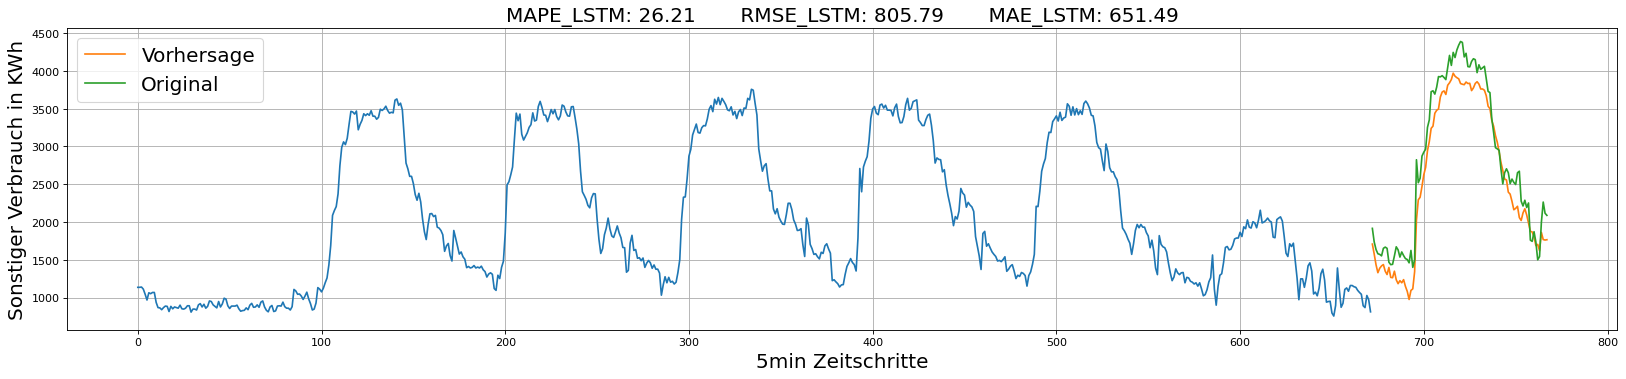

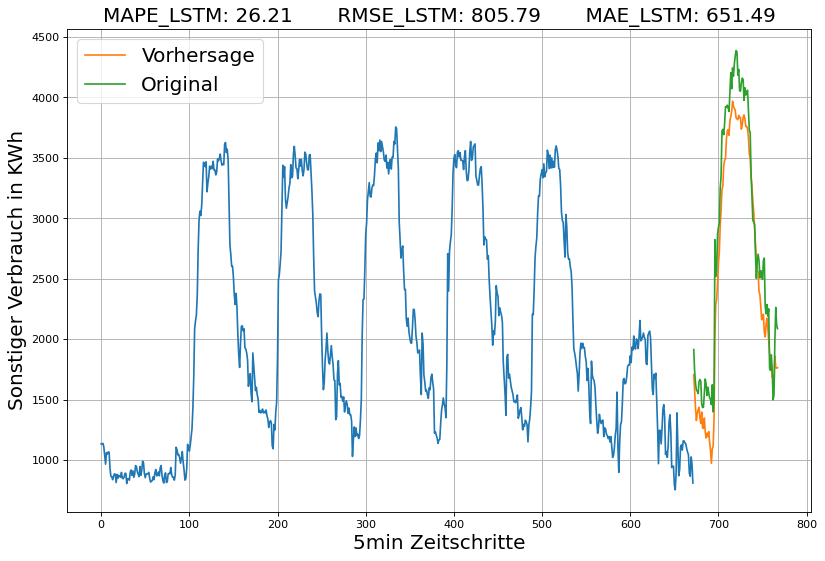

RMSE 369.5579494218596
MAPE 19.414262067237075
MAE 292.25835675663416


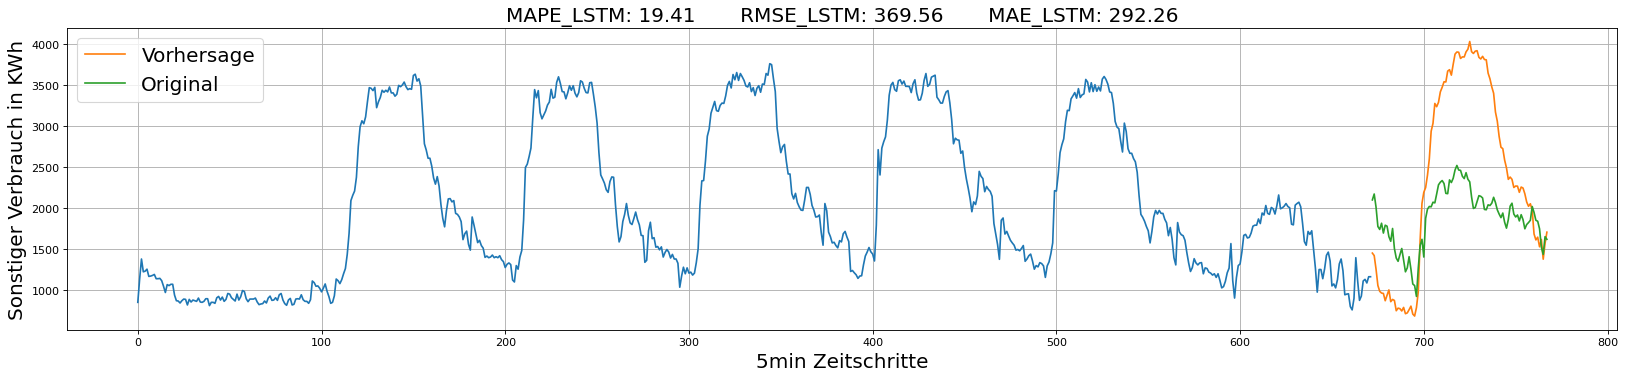

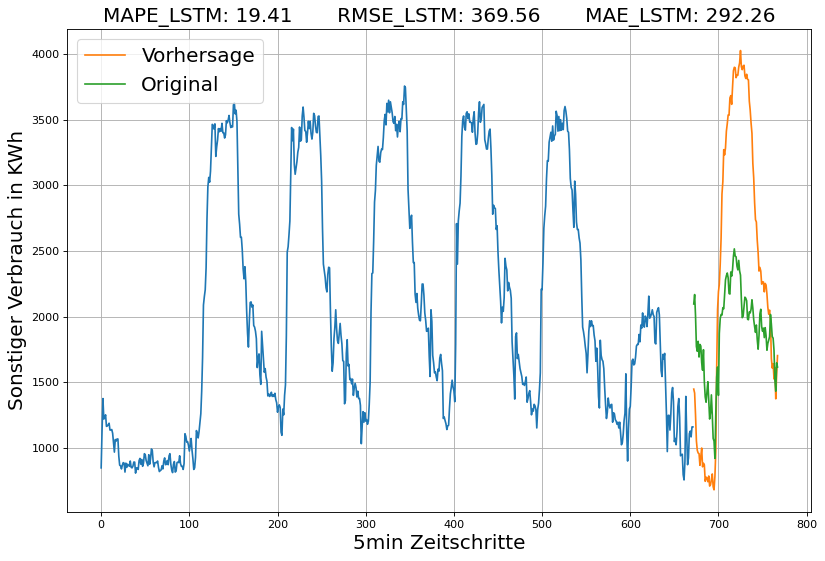

RMSE 368.01303266838465
MAPE 15.986520507306778
MAE 313.7714335123698


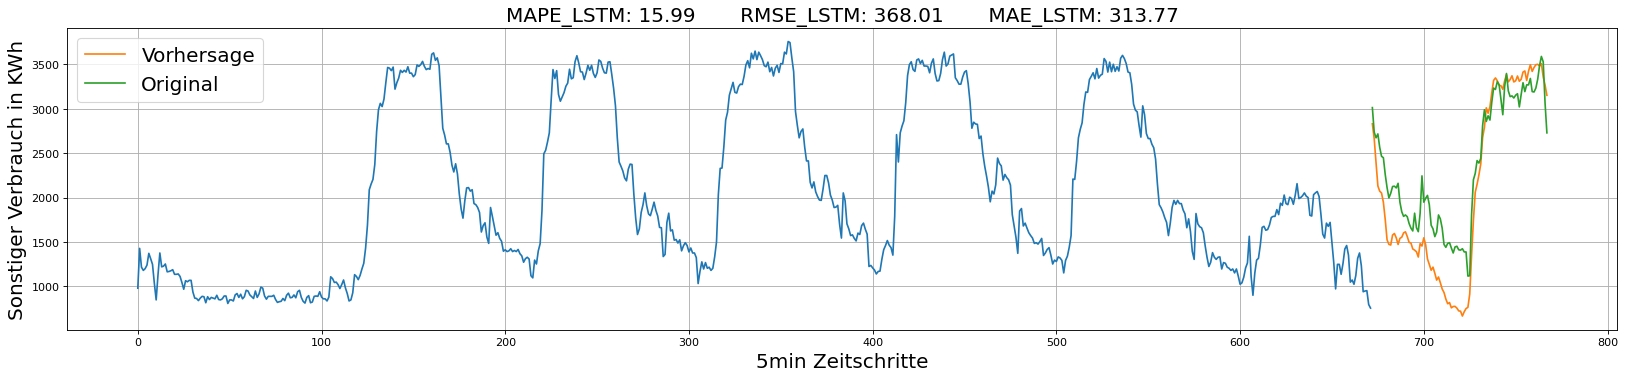

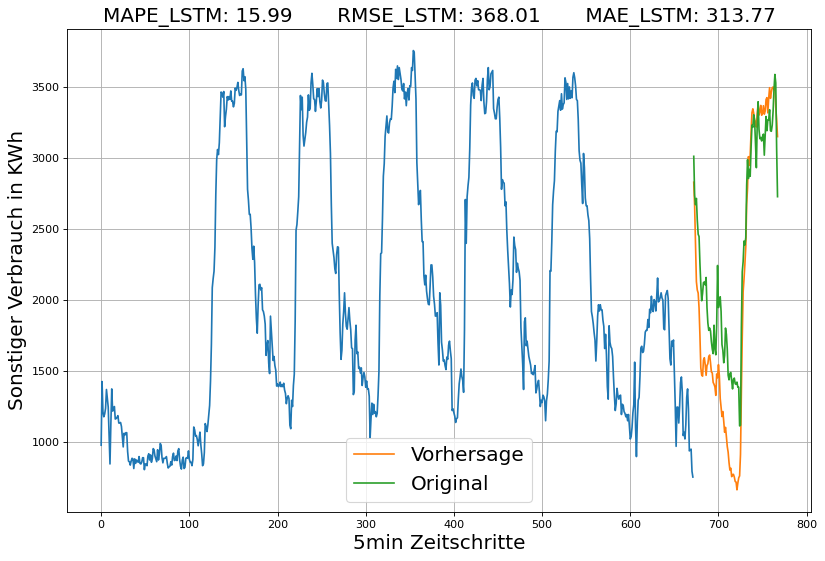

In [32]:
import math

Batches = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
#Batches = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]
for i in Batches:
    Batch = i
    Oneday = 24*12
    start = Batch*Oneday
    end = (Batch + 1)*Oneday
    true = y[start:end]
    pred = x[start:end]
    machine_df = pd.DataFrame(data={
        "true": true,
        "pred": pred
        })
    MAPEs = np.absolute(((true-pred))/true)*100
    MAPEsmean = MAPEs.mean()
    maperound = round(MAPEsmean,2)
    MSE = np.square(np.subtract(true,pred)).mean()
    RMSE = math.sqrt(MSE)
    MAE = np.mean(np.abs(true - pred))
    rmseround = round(RMSE,2)
    maeeround = round(MAE,2)
    print('RMSE', RMSE)
    print('MAPE', MAPEsmean)
    print('MAE', MAE)
    number = 672 + 96
    ranges = []
    for g in range(672,number):
        ranges.append(g)
    ranges = np.asarray(ranges)
    df1 = pd.DataFrame(predicted[i], ranges)
    ranges_ground = []
    for g in range(672,number):
        ranges_ground.append(g)
    ranges_ground = np.asarray(ranges_ground)
    df2 = pd.DataFrame(y_val_multi[i], ranges_ground)
    plt.figure(figsize=(25, 5), dpi=80)
    plt.plot(valMultitest[i][0:672])
    plt.plot(df1, label='Vorhersage')
    plt.plot(df2, label='Original')
    #plt.title('MAPE_LSTM =' + str(maperound),fontsize=18)
    #plt.title('MAPE_LSTM: %s ' %str(maperound) ,fontsize=18)
    plt.title('MAPE_LSTM: ' +str(maperound) + '       RMSE_LSTM: ' + str(rmseround)+ '       MAE_LSTM: ' + str(maeeround) ,fontsize=18)
    plt.xlabel('5min Zeitschritte',fontsize=18)
    plt.ylabel('Sonstiger Verbrauch in KWh',fontsize=18)
    plt.grid()
    plt.legend(fontsize=18)
    plt.show()

    plt.figure(figsize=(12, 8), dpi=80)
    plt.plot(valMultitest[i][0:672])
    plt.plot(df1, label='Vorhersage')
    plt.plot(df2, label='Original')
    #plt.title('MAPE_LSTM =' + str(maperound),fontsize=18)
    #plt.title('MAPE_LSTM: %s ' %str(maperound) ,fontsize=18)
    plt.title('MAPE_LSTM: ' +str(maperound) + '       RMSE_LSTM: ' + str(rmseround)+ '       MAE_LSTM: ' + str(maeeround) ,fontsize=18)
    plt.xlabel('5min Zeitschritte',fontsize=18)
    plt.ylabel('Sonstiger Verbrauch in KWh',fontsize=18)
    plt.grid()
    plt.legend(fontsize=18)
    plt.show()


In [ ]:
# # split a univariate dataset into train/test sets
# def split_dataset(data):
# 	# split into standard weeks
# 	train, test = data[1:-328], data[-328:-6]
# 	# restructure into windows of weekly data
# 	train = array(split(train, len(train)/7))
# 	test = array(split(test, len(test)/7))
# 	return train, test

In [ ]:
# # evaluate one or more weekly forecasts against expected values
# def evaluate_forecasts(actual, predicted):
# 	scores = list()
# 	# calculate an RMSE score for each day
# 	for i in range(actual.shape[1]):
# 		# calculate mse
# 		mse = mean_squared_error(actual[:, i], predicted[:, i])
# 		# calculate rmse
# 		rmse = sqrt(mse)
# 		# store
# 		scores.append(rmse)
# 	# calculate overall RMSE
# 	s = 0
# 	for row in range(actual.shape[0]):
# 		for col in range(actual.shape[1]):
# 			s += (actual[row, col] - predicted[row, col])**2
# 	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
# 	return score, scores

In [ ]:
# # summarize scores
# def summarize_scores(name, score, scores):
# 	s_scores = ', '.join(['%.1f' % s for s in scores])
# 	print('%s: [%.3f] %s' % (name, score, s_scores))
 
# # convert history into inputs and outputs
# def to_supervised(train, n_input, n_out=7):
# 	# flatten data
# 	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
# 	X, y = list(), list()
# 	in_start = 0
# 	# step over the entire history one time step at a time
# 	for _ in range(len(data)):
# 		# define the end of the input sequence
# 		in_end = in_start + n_input
# 		out_end = in_end + n_out
# 		# ensure we have enough data for this instance
# 		if out_end <= len(data):
# 			x_input = data[in_start:in_end, 0]
# 			x_input = x_input.reshape((len(x_input), 1))
# 			X.append(x_input)
# 			y.append(data[in_end:out_end, 0])
# 		# move along one time step
# 		in_start += 1
# 	return array(X), array(y)

In [ ]:
# # train the model
# def build_model(train_x, train_y):
# 	# prepare data
# 	#train_x, train_y = to_supervised(train, n_input)
# 	# define parameters
# 	verbose, epochs, batch_size = 2, 10, 16
# 	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
# 	# define model
# 	model = Sequential()
# 	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
# 	model.add(Dense(100, activation='relu'))
# 	model.add(Dense(n_outputs))
# 	model.compile(loss='mse', optimizer='adam')
# 	# fit network
# 	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
# 	return model

In [ ]:
# def forecast(model, history, n_input):
#     	# flatten data
# 	data = array(history)
# 	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
# 	# retrieve last observations for input data
# 	input_x = data[-n_input:, 0]
# 	# reshape into [1, n_input, 1]
# 	input_x = input_x.reshape((1, len(input_x), 1))
# 	# forecast the next week
# 	yhat = model.predict(input_x, verbose=0)
# 	# we only want the vector forecast
# 	yhat = yhat[0]
# 	return yhat

In [ ]:
# # evaluate a single model
# def evaluate_model(train, test, n_input):
# 	# fit model
# 	model = build_model(train, n_input)
# 	# history is a list of weekly data
# 	history = [x for x in train]
# 	# walk-forward validation over each week
# 	predictions = list()
# 	for i in range(len(test)):
# 		# predict the week
# 		yhat_sequence = forecast(model, history, n_input)
# 		# store the predictions
# 		predictions.append(yhat_sequence)
# 		# get real observation and add to history for predicting the next week
# 		history.append(test[i, :])
# 	# evaluate predictions days for each week
# 	predictions = array(predictions)
# 	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
# 	return score, scores

In [ ]:
# def RNN(past_time_steps):
#     """
#     Arguments:
#     past_time_steps: number of steps needed to predict the next time step.
#     Returns: Model architecture 
    
#     """
#     inputs = Input(name='inputs',shape=(past_time_steps, 1))  
#     #layer = BatchNormalization()(inputs)
#     layer = LSTM(64, return_sequences=True)(inputs)
#     layer = Activation('relu')(layer)
#     layer = Dropout(0.2)(layer)   
#     #layer = LSTM(32, return_sequences=False)(layer)
#     layer = Dense(128,name='FC2', kernel_initializer=initializers.RandomNormal(stddev=0.01),
#     bias_initializer=initializers.Zeros())(layer)
#     layer = Activation('relu')(layer)
#     layer = Dense(1,name='out_layer', kernel_initializer=initializers.RandomNormal(stddev=0.01),
#     bias_initializer=initializers.Zeros())(layer)       
#     model = Model(inputs=inputs,outputs=layer)
#     return model

In [ ]:
# model_lstm = RNN(10079)   
# model_lstm.compile(loss='mse',optimizer='adam',metrics=['accuracy']) 

In [ ]:
import numpy as np
import math
math.factorial(10)*math.factorial(10)

13168189440000

In [ ]:
4**10

1048576

In [ ]:
state_matrix = np.zeros((4, 4))   

reqired_charging_time = np.array([0,1,3,3])
time_left = np.array([1,1,3,3])
state_matrix[reqired_charging_time][time_left] = 1

In [ ]:
np.array([reqired_charging_time, time_left])

array([[0, 1, 3, 3],
       [1, 1, 3, 3]])

In [ ]:
a = np.array([[1,2,3],[1,2,4]])

In [ ]:
a

array([[1, 2, 3],
       [1, 2, 4]])

In [ ]:
a[:,0]

array([1, 1])

In [ ]:
print(a[:, np.all(a[:,]==a[:,], axis=0)])

[[1 2 3]
 [1 2 4]]


In [ ]:
# # Use of random seed to get the same results at every run
# tf.random.set_seed(0)
# np.random.seed(0)

# # Use of the he_uniform initializer to set the initial random weights of the model layers. 
# initializer = tf.keras.initializers.he_uniform(seed=0)

# # Initially, the network model is defined 
# model = Sequential()

# # Hidden layer neurons are chosen to be 11  which is equal to the defined length (number input samples per batch)
# # Selected Activation function has been the rectified linear unit
# model.add(LSTM(10079, activation='relu', input_shape=(10079, 1),kernel_initializer=initializer))

# # The output layer consists of 1 neuron with a 'linear' activation fuction 
# model.add(Dense(1499,activation='linear',kernel_initializer=initializer))
# # The model is compiled using MSE as  loss function and Adam as optimizer
# opt = tf.keras.optimizers.Adam(learning_rate=0.001)
# model.compile(optimizer=opt, loss='mse')

# time_series_generator = TimeseriesGenerator(final_data_X, final_data_y, length=10079, batch_size=1)

# # A validation generator is constructed in a similar way to the previous time_series_generator with the only difference being
# # the use of scaled_test values for validation purposes
# time_series_val_generator = TimeseriesGenerator(final_data_X, final_data_y, length=10079, batch_size=64)

# # The model is trained for 10 epochs. At each epoch both training and validation losses can be observed
# model.fit_generator(time_series_generator,epochs=10,shuffle=False,
#                     validation_data=time_series_val_generator)